In [1]:
import pandas as pd
import numpy as np
import yaml
from ms_pred.common.plot_utils import *
from pathlib import Path
import matplotlib
from pyteomics import mzml, auxiliary
import os

from collections import defaultdict
from scipy.stats import sem

set_style()

In [2]:
# Please download mzml data and change the path 
mzml_path = Path('/home/datashare/msms_data/ullman_nitro_and_iodo_20250411')

results_folder = Path("../../results/figs_iceberg/")

results_folder.mkdir(exist_ok=True, parents=True)

# Ext Data Fig 6 Chromatography

In [3]:
mzml_files = []
for j in mzml_path.iterdir():
    if "blank" in str(j):
        continue
    if "pooled" in str(j): continue
    mzml_files.append(j)
print(len(mzml_files))

8


In [4]:
all_xs = []
all_ys = []
for j in mzml_files:
    print(j)
    these_xs = []
    these_ys = []
    if "nitro" in j.stem:
        tmz = 257.128
    elif "iodo" in j.stem:
        tmz = 212.143
    else:
        print('Unknown spec', j)
    with mzml.MzML(str(j)) as reader:
        for i, spectrum in enumerate(reader):
            if i == 0:
                print(spectrum.keys())
            found = False
            for idx,ii in enumerate(spectrum["m/z array"]):
                if np.abs(ii - tmz) < 0.001:
                    these_ys.append(spectrum["intensity array"][idx])
                    found = True
                    break
            if not found:
                these_ys.append(0)
            these_xs.append(spectrum["scanList"]['scan'][0]['scan start time'])
    all_xs.append(these_xs)
    all_ys.append(these_ys)
    print(len(these_ys), len(these_xs), np.max(these_ys))

/home/datashare/msms_data/ullman_nitro_and_iodo_20250411/nitro_alkyl_ullman_20250411.mzML
dict_keys(['index', 'id', 'defaultArrayLength', 'scanList', 'MS1 spectrum', 'ms level', 'positive scan', 'profile spectrum', 'base peak m/z', 'base peak intensity', 'total ion current', 'lowest observed m/z', 'highest observed m/z', 'count', 'm/z array', 'intensity array'])
20051 20051 4301675520.0
/home/datashare/msms_data/ullman_nitro_and_iodo_20250411/nitro_isopropylaniline_ullman_20250411.mzML
dict_keys(['index', 'id', 'defaultArrayLength', 'scanList', 'MS1 spectrum', 'ms level', 'positive scan', 'profile spectrum', 'base peak m/z', 'base peak intensity', 'total ion current', 'lowest observed m/z', 'highest observed m/z', 'count', 'm/z array', 'intensity array'])
20021 20021 932288192.0
/home/datashare/msms_data/ullman_nitro_and_iodo_20250411/nitro_benzyl_ullman_20250411.mzML
dict_keys(['index', 'id', 'defaultArrayLength', 'scanList', 'MS1 spectrum', 'ms level', 'positive scan', 'profile spect

In [5]:
pool_xs = []
pool_ys257 = []
pool_ys212 = []
with mzml.MzML(str(mzml_path / 'nitro_and_iodo_pooled_ullman_20250411.mzML')) as reader:
    for i, spectrum in enumerate(reader):
        if i == 0:
            print(spectrum.keys())
        found257 = False
        found212 = False
        for idx,ii in enumerate(spectrum["m/z array"]):
            if not found257 and np.abs(ii - 257.128) < 0.001:
                pool_ys257.append(spectrum["intensity array"][idx])
                found257 = True
            if not found212 and np.abs(ii - 212.143) < 0.001:
                pool_ys212.append(spectrum["intensity array"][idx])
                found212 = True
            if found257 and found212:
                break
        if not found257:
            pool_ys257.append(0)
        if not found212:
            pool_ys212.append(0)
        pool_xs.append(spectrum["scanList"]['scan'][0]['scan start time'])


dict_keys(['index', 'id', 'defaultArrayLength', 'scanList', 'MS1 spectrum', 'ms level', 'positive scan', 'profile spectrum', 'base peak m/z', 'base peak intensity', 'total ion current', 'lowest observed m/z', 'highest observed m/z', 'count', 'm/z array', 'intensity array'])


In [6]:
# normalize peak intensities
pool_ys212 = np.array(pool_ys212)
pool_ys257 = np.array(pool_ys257)
all_ys = [np.array(ys) for ys in all_ys]
max_inten = max([np.max(pool_ys212) + np.max(pool_ys257)] + [np.max(ys) for ys in all_ys])

pool_ys212 = pool_ys212 / max_inten
pool_ys257 = pool_ys257 / max_inten
all_ys = [ys / max_inten for ys in all_ys]

# Load MS/MS for the co-eluting peak

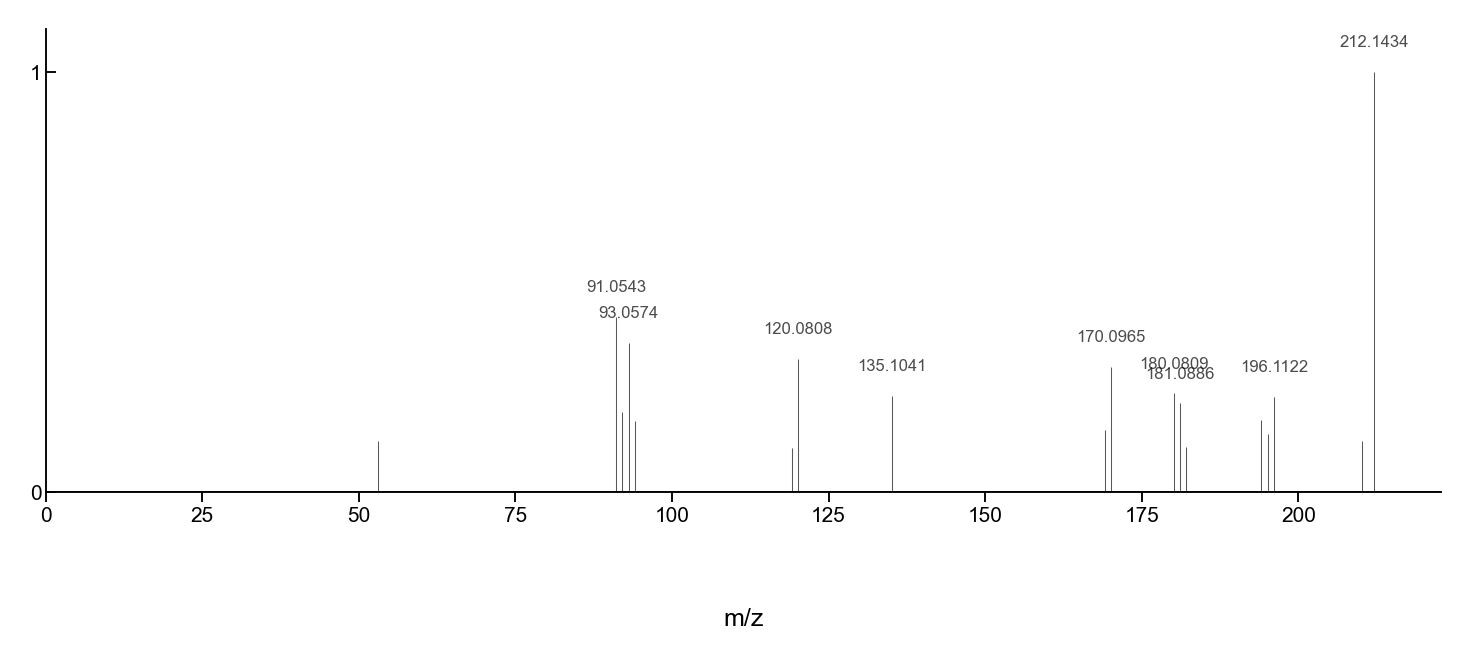

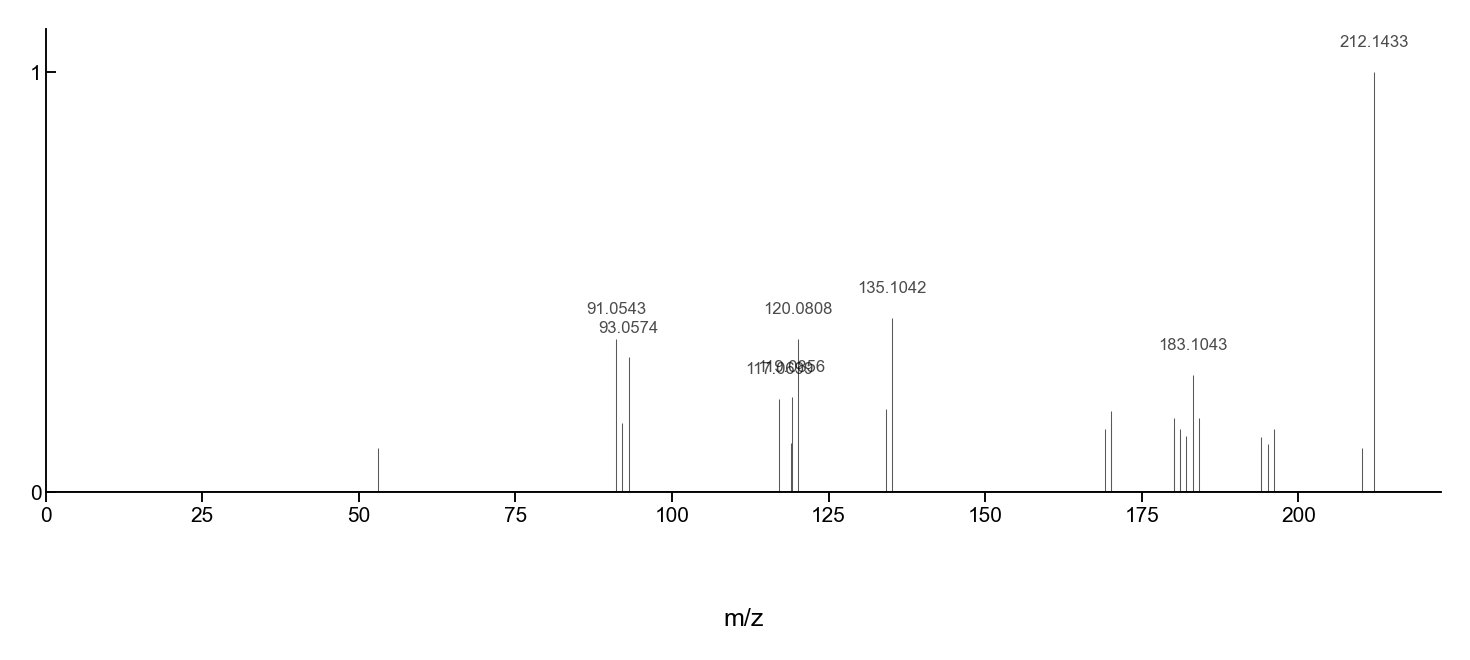

In [7]:
from ms_pred import common

# mzs and intens are extracted from pooled experiment, raw data
all_mzs = [
[65.0387,74.6598,91.0543,91.9062,92.0495,93.0574,94.0652,101.0682,101.5591,106.0652,106.8943,109.4952,113.1854,117.7091,119.0855,120.0808,126.3508,135.1041,160.8612,169.0889,170.0965,180.0809,181.0886,194.0963,195.1040,196.1122,200.5151,212.1434],
[51.1133,51.7257,52.2547,53.0351,54.8757,56.2296,57.4192,57.7760,58.4713,58.6909,58.8861,62.1809,65.0386,67.2169,67.9829,78.7928,80.8177,83.7624,91.0543,91.9073,92.0496,93.0543,93.0574,94.0653,103.0545,106.0652,120.0809,120.0855,131.0731,134.0964,135.1042,150.6048,153.0700,155.4503,167.0737,168.0809,169.0885,170.0964,171.3577,180.0808,181.0886,182.0968,193.9541,194.0965,195.1044,196.1121,197.1199,208.6856,210.1277,212.1434,212.1643],
[51.0232,53.0350,65.0385,70.5860,72.6995,79.0542,82.9689,89.3041,91.0513,91.0543,91.9061,91.9091,92.0495,93.0573,94.0650,106.0650,120.0761,120.0808,134.0963,135.1042,137.9546,145.5597,149.8257,153.0697,168.0804,168.3178,169.0885,170.0963,180.0808,181.0885,182.0966,191.0895,194.0962,195.1043,196.1121,197.1197,210.1275,212.1433,212.6767],
[53.0351,54.5088,65.0387,91.0543,91.9076,92.0467,92.0496,93.0543,93.0574,94.0651,95.2928,106.0651,120.0809,123.1999,134.0965,135.1043,136.7619,137.9254,143.0854,153.0695,157.7873,168.0806,169.0888,170.0964,180.0808,181.0888,182.0966,194.0966,195.1045,196.1121,197.1207,210.1278,212.1320,212.1434],
[53.0351,65.0385,91.0543,91.9053,91.9083,92.0496,93.0574,94.0651,103.0545,106.0651,119.0857,120.0809,127.7293,131.0731,134.0965,135.1042,153.0697,165.4003,168.0809,169.0886,170.0964,180.0807,181.0886,182.0964,183.1041,194.0966,195.1044,196.1121,197.1197,210.1282,212.1434],
[53.0350,67.9866,71.9841,89.5372,91.0517,91.0544,92.0495,93.0574,103.0545,117.0698,117.3706,119.0855,120.0808,124.9924,134.0964,135.1042,137.3235,140.1042,168.0809,169.0887,170.0962,180.0808,181.0882,182.0966,183.1040,184.1120,194.0964,195.1041,196.1120,210.1279,212.1320,212.1434],
[53.0350,65.0386,79.0542,91.0543,91.9057,91.9085,92.0496,93.0574,93.0602,93.0698,103.0541,110.2593,117.0699,119.0731,119.0856,120.0808,123.5046,134.0963,135.1042,135.1097,169.0884,170.0965,178.9617,180.0807,181.0885,182.0964,183.1043,184.1120,194.0967,195.1043,196.1120,204.8851,210.1272,210.9980,212.1433,233.7700],
[53.0351,65.0385,67.1078,79.0543,91.0543,91.9066,92.0495,93.0547,93.0574,103.0542,104.0620,104.6086,106.0651,115.0541,117.0699,119.0729,119.0856,120.0808,120.0855,126.9029,134.0965,135.1042,142.2281,142.2337,169.0884,170.0966,180.0806,181.0886,182.0964,183.1043,184.1123,194.0964,195.1041,196.1122,197.1203,207.8730,210.1278,212.1433,227.9024],
[53.0351,53.4538,59.8154,65.0386,79.0543,85.1691,91.0543,91.9078,92.0495,92.8562,93.0574,93.0699,98.6425,103.0542,106.0651,115.0541,117.0699,119.0729,119.0856,119.5667,120.0808,120.5405,121.6822,134.0965,135.1042,135.1097,139.9886,153.8650,168.0813,169.0882,170.0965,178.4134,180.0805,181.0884,182.0965,183.1042,184.1123,194.0969,195.1043,196.1122,197.1201,198.8276,210.1277,212.1433]]
all_intens = [
[2.2E5,1.8E5,1.3E7,4.9E5,5.9E5,2.0E6,2.1E6,1.9E5,2.1E5,3.1E5,1.9E5,1.9E5,2.3E5,1.8E5,8.0E5,1.6E6,1.9E5,9.7E5,2.1E5,2.5E5,1.5E6,7.8E5,6.8E5,6.5E5,4.0E5,8.2E5,2.0E5,1.8E7],
[1.7E5,1.8E5,1.6E5,1.1E6,1.8E5,1.6E5,1.8E5,1.5E5,1.6E5,1.8E5,1.5E5,1.8E5,4.8E5,1.7E5,2.0E5,1.9E5,2.0E5,2.0E5,8.6E6,3.0E5,2.7E6,3.9E5,9.4E6,5.6E5,2.4E5,7.1E5,7.5E6,2.5E5,2.0E5,3.9E5,3.9E6,2.2E5,5.2E5,2.1E5,2.5E5,5.9E5,1.6E6,6.6E6,2.1E5,4.1E6,3.3E6,8.4E5,2.1E5,2.2E6,1.4E6,3.8E6,3.1E5,2.2E5,1.1E6,7.5E7,4.6E5],
[2.2E5,5.9E5,4.1E5,2.1E5,2.1E5,2.0E5,1.9E5,1.9E5,3.5E5,7.5E6,5.1E5,3.0E5,2.6E6,7.3E6,2.9E5,6.3E5,2.2E5,6.4E6,6.3E5,3.0E6,2.3E5,1.9E5,2.1E5,5.9E5,5.6E5,2.2E5,9.7E5,5.8E6,3.0E6,2.4E6,5.9E5,2.1E5,2.3E6,9.8E5,2.7E6,3.1E5,9.7E5,4.9E7,2.1E5],
[6.1E5,2.1E5,4.1E5,6.8E6,3.4E5,2.5E5,3.2E6,2.7E5,8.1E6,4.2E5,2.1E5,5.3E5,6.1E6,2.3E5,2.9E5,3.2E6,2.1E5,2.3E5,2.6E5,5.0E5,2.1E5,5.1E5,1.2E6,6.5E6,3.9E6,2.5E6,7.4E5,2.2E6,1.4E6,3.1E6,2.3E5,6.7E5,4.8E5,5.0E7],
[5.5E5,5.4E5,7.3E6,4.3E5,5.2E5,2.6E6,7.7E6,3.6E5,2.3E5,8.3E5,2.2E5,6.4E6,2.3E5,2.3E5,4.3E5,3.8E6,2.6E5,2.2E5,5.7E5,1.6E6,5.3E6,3.8E6,2.9E6,8.9E5,2.5E5,2.2E6,1.3E6,3.2E6,3.2E5,1.1E6,4.6E7],
[3.2E5,2.0E5,2.3E5,2.2E5,3.0E5,3.4E6,1.1E6,2.5E6,2.0E5,5.3E5,2.0E5,7.2E5,2.7E6,2.0E5,7.9E5,3.5E6,2.1E5,1.9E5,2.3E5,4.3E5,1.4E6,1.1E6,7.2E5,4.5E5,1.1E6,6.1E5,6.7E5,3.9E5,1.1E6,4.6E5,3.6E5,3.4E7],
[4.5E5,3.3E5,3.7E5,4.9E6,2.8E5,4.6E5,1.3E6,4.5E6,4.2E5,2.4E5,4.7E5,2.2E5,2.1E6,3.7E5,2.0E6,6.0E6,2.3E5,1.7E6,7.7E6,3.6E5,8.2E5,1.4E6,2.3E5,1.6E6,9.7E5,6.8E5,2.6E6,1.0E6,3.1E5,3.2E5,8.7E5,2.3E5,3.3E5,2.2E5,4.4E7,2.2E5],
[5.0E5,3.2E5,2.1E5,3.1E5,5.8E6,3.5E5,1.3E6,2.9E5,3.6E6,3.6E5,3.0E5,2.2E5,3.9E5,4.8E5,2.4E6,5.7E5,2.5E6,6.5E6,2.4E5,2.1E5,1.5E6,8.3E6,2.0E5,2.1E5,1.1E6,1.4E6,1.5E6,9.0E5,8.5E5,3.6E6,1.0E6,8.2E5,2.9E5,8.2E5,2.7E5,2.0E5,4.6E5,4.4E7,2.5E5],
[5.3E5,1.9E5,2.0E5,4.5E5,2.7E5,2.1E5,6.5E6,2.3E5,1.2E6,2.3E5,5.0E6,3.4E5,1.9E5,3.8E5,2.6E5,3.3E5,2.0E6,6.6E5,2.3E6,2.2E5,6.2E6,2.0E5,1.9E5,1.9E6,8.4E6,2.0E5,2.2E5,2.1E5,2.8E5,1.0E6,1.8E6,2.0E5,1.1E6,1.1E6,7.6E5,3.8E6,1.5E6,5.5E5,6.3E5,1.1E6,4.8E5,2.2E5,5.3E5,4.9E7]
]

all_peaks = [(str(i), np.array([[mz, inten] for inten, mz in zip(all_intens[i], all_mzs[i])])) for i in range(0, 2)]
spec_elute1 = common.process_spec_file({"parentmass": 212.1432}, all_peaks, precision=3)
spec_elute1 = common.max_inten_spec(spec_elute1, inten_thresh=0.1)
common.plot_ms(spec_elute1)
for mz, inten in spec_elute1:
    if inten > 0.2:
        plt.text(mz, inten + 0.06, f'{mz:.4f}', fontsize=4, alpha=0.7, horizontalalignment='center')


all_peaks = [(str(i), np.array([[mz, inten] for inten, mz in zip(all_intens[i], all_mzs[i])])) for i in range(7, 9)]
spec_elute2 = common.process_spec_file({"parentmass": 212.1432}, all_peaks, precision=3)
spec_elute2 = common.max_inten_spec(spec_elute2, inten_thresh=0.1)
common.plot_ms(spec_elute2)
for mz, inten in spec_elute2:
    if inten > 0.2:
        plt.text(mz, inten + 0.06, f'{mz:.4f}', fontsize=4, alpha=0.7, horizontalalignment='center')

In [8]:
from scipy.signal import hilbert, find_peaks

new_all_ys = []
for xs, ys in zip(all_xs + [pool_xs, pool_xs], all_ys + [pool_ys212, pool_ys257]):
    xs_arr = np.array(xs)
    ys_arr = np.array(ys)
    peaks, _ = find_peaks(ys_arr)
    # interpolate between those peaks
    env = np.interp(xs_arr,
                    xs_arr[peaks],
                    ys_arr[peaks])
    new_all_ys.append(env)

new_pool_ys212 = new_all_ys[-2]
new_pool_ys257 = new_all_ys[-1]
new_all_ys = new_all_ys[:-2]

In [9]:
[(_.min(), _.max()) for _ in new_all_ys]

[(1.8099415733498875e-07, 0.4580483153522356),
 (2.5421650498433395e-07, 0.09927132666863296),
 (5.058192250170517e-07, 0.036792101610420874),
 (2.956151681648823e-07, 0.39980703190038824),
 (6.825682694914111e-07, 1.0),
 (2.631026823148193e-07, 0.04385687322440181),
 (4.41256053880664e-07, 0.05568652442617955),
 (3.281348290293335e-07, 0.14193522007195347)]

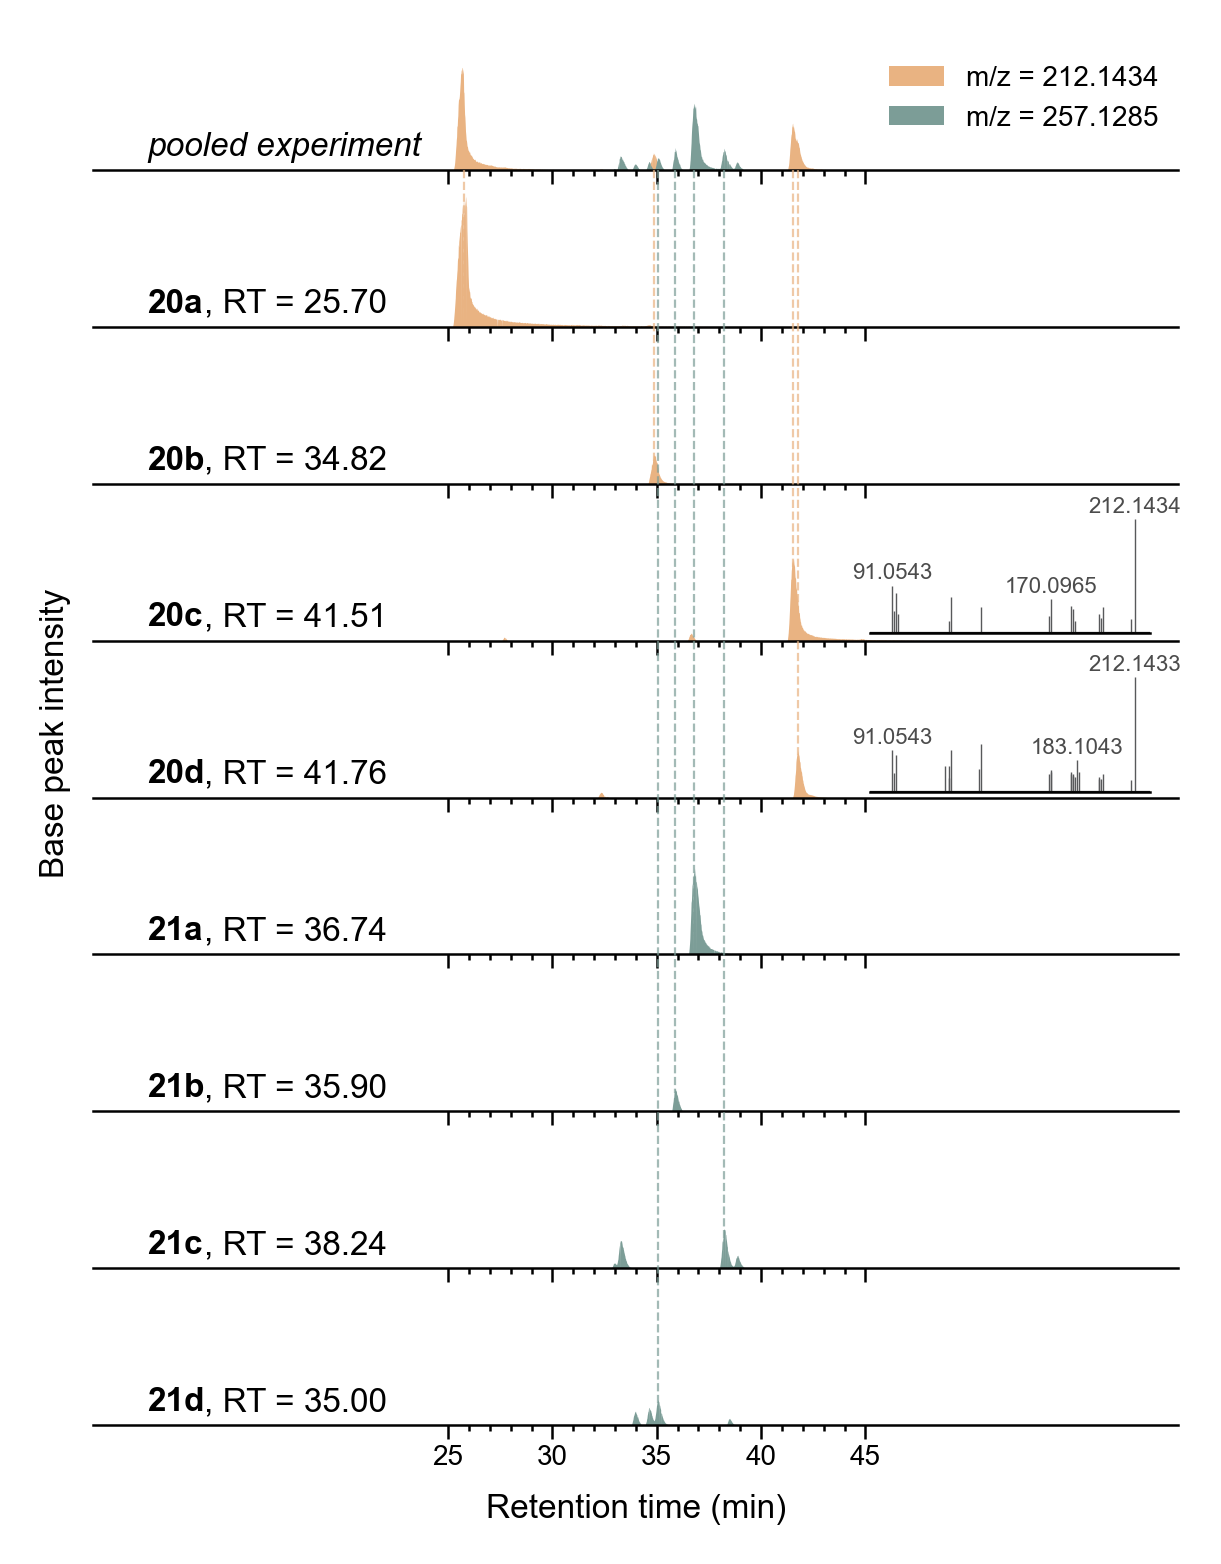

In [10]:
import matplotlib.pyplot as plt
from matplotlib import gridspec
import numpy as np
from matplotlib.patches import Patch

fig = plt.figure(figsize=(3.5, 4.5), dpi=400)
gs = gridspec.GridSpec(9, 1, hspace=0.2)

ax_pool = plt.subplot(gs[0, 0])
ax_indi = [plt.subplot(gs[i+1, 0], sharex=ax_pool, sharey=ax_pool) for i in range(8)]

# ax_pool.plot(np.array(pool_xs), np.sqrt(new_pool_ys212), color='#e9b382', linewidth=0.1)
ax_pool.fill_between(np.array(pool_xs), np.zeros_like(new_pool_ys212), np.sqrt(new_pool_ys212), color='#e9b382', linewidth=0)
# ax_pool.plot(np.array(pool_xs), np.sqrt(new_pool_ys257), color='#7c9d97', linewidth=0.1)
ax_pool.fill_between(np.array(pool_xs), np.zeros_like(new_pool_ys257), np.sqrt(new_pool_ys257), color='#7c9d97', linewidth=0)
ax_pool.set_yticks([])
ax_pool.tick_params(axis='x', labelbottom=False)
ax_pool.tick_params(axis='x', which='minor', length=1)
ax_pool.text(0.05, 0.18, "pooled experiment", transform=ax_pool.transAxes, ha='left', va='center', rotation=0, style='italic')
ax_pool.set_xlim(8, 60)
ax_pool.set_ylim(0.02, 1)

# turn off boxes
for spine in ['top', 'right', 'left']:
    ax_pool.spines[spine].set_visible(False)

plot_order = [4, 6, 3, 7, 0, 2, 1, 5]
xtick_pos = [25, 30, 35, 40, 45]
xminortick_pos = [i for i in range(xtick_pos[0], xtick_pos[-1]) if not i in xtick_pos]

name0_to_bb = {'nitro': '19', 'iodo': '18'}
name1_to_bb = {'alkyl': '17a', 'benzyl': '17b', 'isopropylaniline': '17c', 'meth-eth-aniline': '17d'}
name0_to_prod = {'nitro': '21', 'iodo': '20'}
name1_to_prod = {'alkyl': 'a', 'benzyl': 'b', 'isopropylaniline': 'c', 'meth-eth-aniline': 'd'}
name_to_rt = {'iodo-alkyl': '25.70', 'iodo-benzyl': '34.82', 'iodo-isopropylaniline': '41.51', 'iodo-meth-eth-aniline': '41.76',
             'nitro-alkyl': '36.74', 'nitro-benzyl': '35.90', 'nitro-isopropylaniline': '38.24', 'nitro-meth-eth-aniline': '35.00'}

for pidx, i in enumerate(plot_order):
    names = mzml_files[i].stem.split("_")[0:2]
    color = '#7c9d97' if names[0] == 'nitro' else '#e9b382'

    ax = ax_indi[pidx]
    ax.fill_between(all_xs[i], np.zeros_like(new_all_ys[i]), np.sqrt(new_all_ys[i]), color=color, linewidth=0)
    ax.set_yticks([])
    ax.set_xticks(xtick_pos)
    ax.set_xticks(xminortick_pos, minor=True)
    ax.tick_params(axis='x', labelbottom=False)
    ax.tick_params(axis='x', which='minor', length=1)

#     ax.text(0.05, 0.18, f'{name1_to_bb[names[1]]}+{name0_to_bb[names[0]]}', weight='bold',
#             transform=ax.transAxes, ha='left', va='center', rotation=0)
#     ax.text(0.155, 0.18, f', RT={name_to_rt["-".join(names)]}',
#             transform=ax.transAxes, ha='left', va='center', rotation=0)
    ax.text(0.05, 0.18, f'{name0_to_prod[names[0]]}{name1_to_prod[names[1]]}', weight='bold',
            transform=ax.transAxes, ha='left', va='center', rotation=0)    
    ax.text(0.102, 0.18, f', RT = {name_to_rt["-".join(names)]}',
            transform=ax.transAxes, ha='left', va='center', rotation=0)

    for spine in ['top', 'right', 'left']:
        ax.spines[spine].set_visible(False)
        
    # Find highest peak x location in data coordinates
    x_peak = all_xs[i][np.argmax(all_ys[i])]

    # Convert data x-coordinate to figure normalized coordinate
    x_fig = ax.transData.transform((x_peak, 0))[0]
    x_fig_norm = fig.transFigure.inverted().transform((x_fig, 0))[0]

    # Get y limits for the pooled subplot and current subplot in figure coords
    y0 = ax_pool.get_position().y0  # bottom of ax_pool
    y1 = ax.get_position().y0       # bottom of current subplot

    # Add a vertical dashed line across subplots using figure coordinates
    line = plt.Line2D(
        [x_fig_norm, x_fig_norm], [y0, y1 + 0.01],
        transform=fig.transFigure,
        linestyle='--',
        linewidth=0.4,
        color=color,
        alpha=0.7,
        zorder=1
    )
    fig.lines.append(line)

# Define legend handles using rectangle patches
legend_handles = [
    Patch(facecolor='#e9b382', edgecolor='none', label='m/z = 212.1434'),
    Patch(facecolor='#7c9d97', edgecolor='none', label='m/z = 257.1285')
]

# Add custom legend to upper left with padding
ax_pool.legend(
    handles=legend_handles,
    loc='upper left',
    bbox_to_anchor=(0.71, 0.99),
    frameon=False,
)

ax_indi[3].set_ylabel('Base peak intensity')
ax_indi[7].tick_params(axis='x', labelbottom=True)
ax_indi[7].set_xticklabels(xtick_pos)
ax_indi[7].set_xlabel('Retention time (min)')

# --- Add Floating (Inset) MS/MS Panels ---
# Here we add two inset axes to float on top of the LC plot.
# Adjust the positions ([left, bottom, width, height] in figure fraction coordinates) as desired.
inset_ax1 = fig.add_axes([0.68, 0.55, 0.2, 0.07])  # Example: top-right corner inset
common.plot_ms(spec_elute1, ax=inset_ax1, spec_name="")
for spine in ['top', 'right', 'left']:
    inset_ax1.spines[spine].set_visible(False)
inset_ax1.set_facecolor("none")
inset_ax1.set_yticks([])
inset_ax1.set_yticks([], minor=True)
inset_ax1.set_xticks([])
inset_ax1.set_xlabel("")
inset_ax1.set_ylabel("")
inset_ax1.set_xlim(80, 220)
# Optionally, label the peaks on the inset:
for mz, inten in spec_elute1:
    if inten > 0.25 and (mz > 170 or mz < 93):
        inset_ax1.text(mz, inten + 0.06, f'{mz:.4f}', fontsize=4, alpha=0.7, horizontalalignment='center')

inset_ax2 = fig.add_axes([0.68, 0.462, 0.2, 0.07])  # Example: below the first inset
common.plot_ms(spec_elute2, ax=inset_ax2, spec_name="")
for spine in ['top', 'right', 'left']:
    inset_ax2.spines[spine].set_visible(False)
inset_ax2.set_facecolor("none")
inset_ax2.set_yticks([])
inset_ax2.set_yticks([], minor=True)
inset_ax2.set_xticks([])
inset_ax2.set_xlabel("")
inset_ax2.set_ylabel("")
inset_ax2.set_xlim(80, 220)
for mz, inten in spec_elute2:
    if inten > 0.25 and (mz > 170 or mz < 93):
        inset_ax2.text(mz, inten + 0.06, f'{mz:.4f}', fontsize=4, alpha=0.7, horizontalalignment='center')

plt.show()
fig.savefig(
    results_folder / "pooled_bh_lc.pdf", bbox_inches="tight", transparent=True
)

# Fig 4 pooled vs unpooled regression

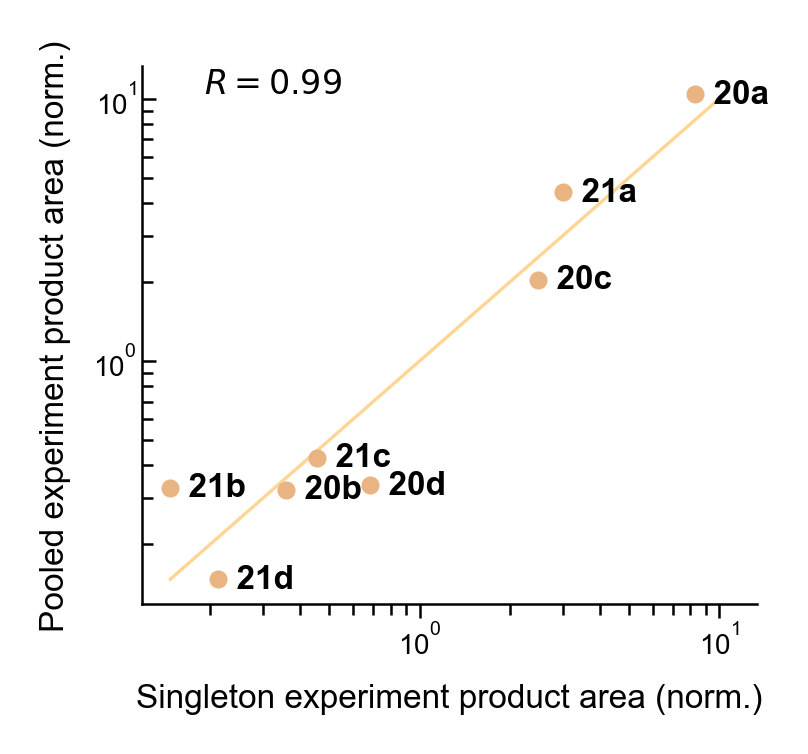

In [11]:
import numpy as np
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(2., 1.8), dpi=400)

# Provided data
labels = ['20a', '20c', '20d', '20b', '21a', '21b', '21d', '21c']
individual_areas = np.array([8.27, 2.48, 0.683, 0.357, 3.00, 0.147, 0.213, 0.454])
pooled_areas = np.array([10.4, 2.044, 0.336, 0.322, 4.39, 0.328, 0.147, 0.428])

n = len(individual_areas)  # number of data points

###############################################################################
# NORMAL SCALE REGRESSION (Additive Model, forced through origin)
###############################################################################
# Compute the slope forcing the regression through 0:
slope_norm = np.sum(individual_areas * pooled_areas) / np.sum(individual_areas**2)
slope_norm = 1 # force slope=1, parity line
intercept_norm = 0  # forced through origin

def regression_line_norm(x):
    return slope_norm * x

# Predicted values and RMSE for the normal regression
predicted_norm = regression_line_norm(individual_areas)
rmse_norm = np.sqrt(np.mean((predicted_norm - pooled_areas)**2))

# Define x values (for plotting the regression line)
x_vals = np.linspace(individual_areas.min(), individual_areas.max() * 1.3, 100)
y_vals_norm = regression_line_norm(x_vals)

###############################################################################
# Compute Pearson's correlation coefficient (R)
###############################################################################
pearson_r = np.corrcoef(individual_areas, pooled_areas)[0, 1]

###############################################################################
# PLOTTING (displayed on log scale)
###############################################################################
# Plot the data points
plt.scatter(individual_areas, pooled_areas, color='#E9B382', zorder=3, s=6)

# Set log scale for both axes
plt.xscale('log')
plt.yscale('log')

# Add labels for each point
for x, y, lab in zip(individual_areas, pooled_areas, labels):
    plt.text(x, y, f'  {lab}', verticalalignment='center', weight='bold')

# Plot the regression line with RMSE and Pearson's R in the legend
plt.plot(x_vals, y_vals_norm, color='#FFD593', linewidth=0.6,
         label=f"Pearson's R = {pearson_r:.2f}")
# RMSE = {rmse_norm:.4f}, 

# Label the axes
plt.xlabel('Singleton experiment product area (norm.)')
plt.ylabel('Pooled experiment product area (norm.)')

for spine in ['top', 'right']:
    plt.gca().spines[spine].set_visible(False)

plt.text(0.1, 0.95, f'$R = {pearson_r:.2f}$', transform=plt.gca().transAxes, horizontalalignment='left')
# \n$y = e^{{ {slope_norm:.3f} \cdot \\log x}}$ 

plt.tight_layout()
plt.show()

fig.savefig(
    results_folder / "pooled_vs_individual.pdf", bbox_inches="tight", transparent=True
)